# Прогнозирование оттока клиентов для оператора связи

**Описание проекта**

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Исследовательский анализ

In [4]:
# импортируем все необходимые библиотеки и инструменты

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime 

from sklearn.model_selection import GridSearchCV , train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import lightgbm 
import catboost 
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [6]:
# загрузим предоставленные нам датасеты 

contract_data = pd.read_csv('/datasets/contract_new.csv') # информация о договоре
personal_data = pd.read_csv('/datasets/personal_new.csv') # персональные данные клиента
internet_data = pd.read_csv('/datasets/internet_new.csv') # информация об интернет-услугах
phone_data = pd.read_csv('/datasets/phone_new.csv') # информация об услугах телефонии

In [7]:
# посмотрим содержание датасетов и информацию о них
# начнем с contract_data

contract_data.head()

customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  
0           Electronic check           29.85        31.04  
1               Mailed check           56.95      2071.84  
2               Mailed check           53.85       226.17  
3  Bank transfer (automatic)           42.30       1960.6  
4           Electronic check           70.70        353.5

In [8]:
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [9]:
contract_data.duplicated().sum()

0

В первом датасете нет пропусков и явных дубликатов. Но есть неверные форматы данных, в столбцах `BeginDate`, `EndDate`, `TotalCharges`. В первых двух должен быть формат даты, в последнем числовой с плавающей запятой. 

In [10]:
# проверим наличие неявных пропусков, посмотрев, какие значения вообще есть в столбцах

contract_data['EndDate'].value_counts()

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2015-04-01       2
2014-06-01       1
2014-11-01       1
2014-10-01       1
Name: EndDate, Length: 67, dtype: int64

Столбец `EndDate` является для нас, видимо, целевым. Здесь, в отличие от столбца `BeginDate`, есть не только даты, но и значение 'No', которое означает, что клиент на данный момент не отказался от услуг компании. 

In [11]:
contract_data['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

Столбец `Type` - тип оплаты, то есть долгосрочные контракты на год, два или же оплата производится ежемесячно и ежемесячно продлевается.

In [12]:
contract_data['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

В столбце `PaymentMethod` представлены доступные способы оплаты: электронный чек, почтовый чек, банковский перевод и кредитная карта

In [13]:
contract_data['TotalCharges'].value_counts()

           11
20.45       6
101.0       5
1007.5      4
19.65       4
           ..
6255.79     1
45.99       1
468.94      1
380.63      1
7021.1      1
Name: TotalCharges, Length: 6658, dtype: int64

В столбце `TotalCharges` (суммарные расходы на услуги клиента) есть пустое значение, и таких пустых значений 11. То есть тут имеются неявные пропуски.

In [14]:
# посмотреть на суммарные траты не можем, пока не поменяем тип данных
# поэтому ознакомимся со значениями в столбце 'MonthlyCharges' (месячные расходы)

contract_data['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

Среднее значение почти совпадает с медианным. 

<AxesSubplot:>

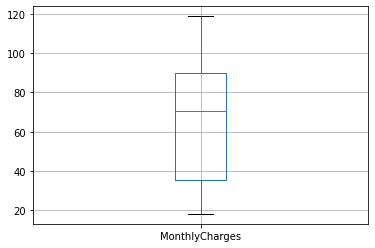

In [15]:
contract_data.boxplot('MonthlyCharges')

Выбросов нет. Данные немного скошены влево.

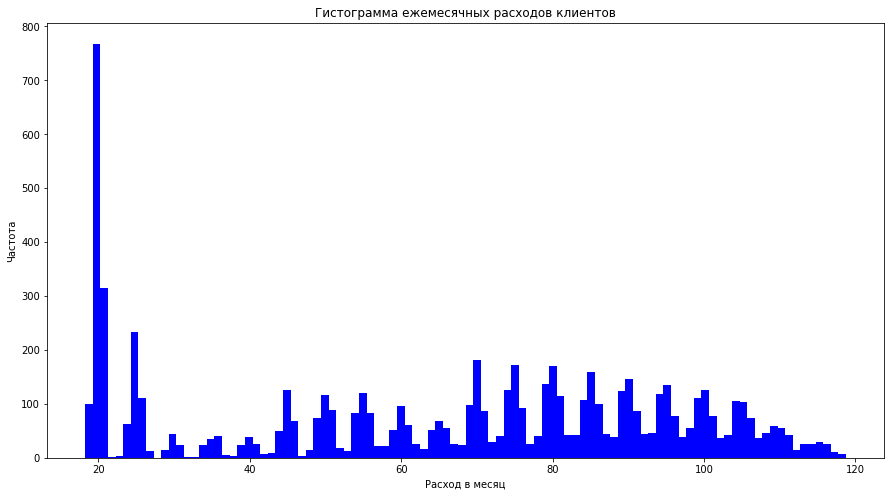

In [16]:
plt.figure(figsize=(15,8))
plt.hist(contract_data['MonthlyCharges'], color='blue', bins=100)
plt.title('Гистограмма ежемесячных расходов клиентов')
plt.ylabel('Частота')
plt.xlabel('Расход в месяц')
plt.show()

БОльшая часть ежемесячных платежей приходится на примерно 20(долларов?) денежных единиц. Есть и довольно высокие значения, однако, скорее всего, это те клиенты, у которых подключено много услуг и телефонии, и интернета, возможно ТВ. Также можно сказать, что четкие пики на круглых числах, это может означать определенные тарифы, цены на которые всегда округлённые.

In [17]:
# приступим ко второму датафрейму

personal_data.head()

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

In [18]:
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [19]:
personal_data.duplicated().sum()

0

Явных дубликатов и пропусков нет.

In [20]:
personal_data['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

Мужчин и женщин примерно одинаковое количество.

In [21]:
personal_data['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

Столбцец `SeniorCitizen` говорит о том, является ли пенсионером клиент. НЕ пенсионеров в 5 раз больше, чем пенсионеров.

In [22]:
personal_data['Partner'].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

Также почти одинаковое число тех, у кого есть супруг/а, и тех, у кого нет.

In [23]:
personal_data['Dependents'].value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

Столбец `Dependents` - иждивенцы(дети, больные родственники). В 2 раза больше тех, у кого их нет.

В этом датафрейме нет дубликатов и пропусков. Но бинарные признаки обозначены в столбцах по разному: в столбце пенсионного статуса 0 и 1, в остальных иначе.

In [24]:
# посмотрим на третий датафрейм

internet_data.head()

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

In [25]:
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [26]:
internet_data.duplicated().sum()

0

Пропусков и дубликатов нет. И все признаки, кроме одного - бинарные.

In [27]:
internet_data['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

В столбце `InternetService` тоже всего два значения - два типа интернет-подключения: оптоволокно и по обычной витой паре. Больше клиентов подключены через оптическое волокно, но разница незначительна.

In [28]:
# посмотрим на последний датафрейм

phone_data.head()

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

In [29]:
phone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [30]:
phone_data.duplicated().sum()

0

Дубликатов и пропусков нет. В датафрейме всего один столбец помимо идентификатора - `MultipleLines`, это наличие или отсутствие услуги нескольких телефонных линий одновременно.

<AxesSubplot:>

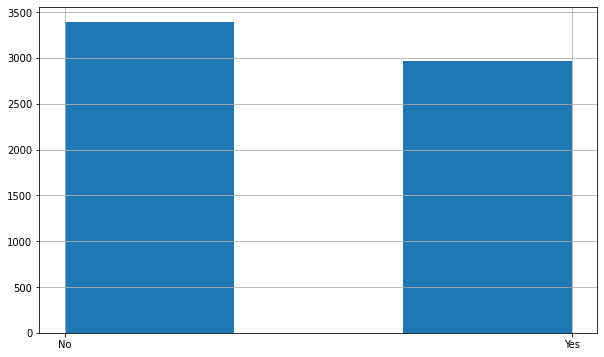

In [31]:
phone_data['MultipleLines'].hist(bins=3, figsize=(10, 6))

Распределение имеющих эту услугу и не имеющих её примерно одинаково.

**Резюме подготовительного этапа проекта:**

- Нам предоставлены 4 датасета: с персональными данными, данными по телефонии, данными по интернету, данными о договоре. Все датасеты имеют общий столбец - `customerID`.

- Каждый из датасетов загрузили и просмотрели общую информацию. В каждом 7043 строки, то есть столько клиентов. 

- Пропусков явных ни в одном датасете нет, однако в датасете contract_data в столбце TotalCharges (суммарные расходы на услуги клиента) есть 11 пустых значений.

- Явных дубликатов обнаружено не было.

- есть столбцы с неверными форматами данных: BeginDate и EndDate  - object вместо datetime, TotalCharges - object вместо численного. 

- ознакомились с тем, что содержат в себе столбцы и как относительно друг друга распределены значения.

# Цель проекта

Построить модель, которая будет прогнозировать, уйдёт ли клиент. Это необходимо для того, чтобы предложить акции, специальные условия, еще какие-то бонусы, чтобы клиента не потерять.  

# План решения поставленной задачи

1. Выполнить предобработку данных(после ознакомления с данными, осуществленного выше)

    - исправить неверные типы данные, обнаруженные в ходе первого этапа
    
    - соединить все таблицы в одну по идентификатору клиента
    
    - устранить пропуски, которые могли возникнуть при соединении таблиц
    
    - посмотреть на то, как признаки коррелируют друг с другом
    
    - проверить, стоит ли использовать все признаки, а также необходимо ли создать новые признаки
    
2. Подготовить данные для обучения

    - разделить выборку на обучающую и тестовую
    
    - выделить признаки и целевой признак

    - закодировать признаки (OHE)
    
    
3. Обучение моделей 

    - определить, какие использовать модели
    
    - для каждой выбранной модели подобрать такие гиперпараметры, при которых на обучающей выборке, с кросс-валидацией, метрика качества модели будет наилучшей
    
    - сравнить метрики, полученные для каждой модели
    
    - выбрать ту модель, для которой выбранная метрика оказалась наилучшей
    
4. Проверить эффективность выбранной модели на тестовой выборке  

       
     - Провести анализ лучшей модели (важность признаков, матрица ошибок)
    


5. Выводы о работе и полученных результатах.

## Предобработка данных

In [32]:
# зададим константу

RANDOM_STATE = 250423

In [33]:
pip install phik

     |████████████████████████████████| 679 kB 1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [34]:
# импортируем установленную выше необходимую для дальнейшей работы (матрица корреляции) библиотееку phik

import phik
from phik import report
from phik.report import plot_correlation_matrix

In [35]:
# посмотрим на те строки, где значения 'TotalCharges' пропущены

contract_data.loc[contract_data['TotalCharges'] == ' ']

customerID   BeginDate EndDate      Type PaperlessBilling  \
488   4472-LVYGI  2020-02-01      No  Two year              Yes   
753   3115-CZMZD  2020-02-01      No  Two year               No   
936   5709-LVOEQ  2020-02-01      No  Two year               No   
1082  4367-NUYAO  2020-02-01      No  Two year               No   
1340  1371-DWPAZ  2020-02-01      No  Two year               No   
3331  7644-OMVMY  2020-02-01      No  Two year               No   
3826  3213-VVOLG  2020-02-01      No  Two year               No   
4380  2520-SGTTA  2020-02-01      No  Two year               No   
5218  2923-ARZLG  2020-02-01      No  One year              Yes   
6670  4075-WKNIU  2020-02-01      No  Two year               No   
6754  2775-SEFEE  2020-02-01      No  Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges  
488   Bank transfer (automatic)           52.55               
753                Mailed check           20.25               
936                Mailed check           80.85               
1082               Mailed check           25.75               
1340    Credit card (automatic)           56.05               
3331               Mailed check           19.85               
3826               Mailed check           25.35               
4380               Mailed check           20.00               
5218               Mailed check           19.70               
6670               Mailed check           73.35               
6754  Bank transfer (automatic)           61.90

Для всех пропусков в 'TotalCharges' дата начала пользования услугами - последняя актуальная дата, то есть это новые пользователи, для которых суммарных платежей нет, то есть их можно заменить на тот месячный платеж, который они заплатили при подключении. 

In [36]:
# в столбце 'EndDate' заменим значение 'No' на последнюю актуальную дату (дата выгрузки, 1 февраля 2020)
# в 'TotalCharges' заменим неявные пропуски нулями
# и изменим тип данных в 'EndDate' и 'BeginDate' на формат даты, а в 'TotalCharges' на числовой

contract_data['EndDate'] = contract_data['EndDate'].replace(['No'], ['2020-02-01'])
#contract_data['TotalCharges'] = contract_data['TotalCharges'].replace([' '], contract_data['MonthlyCharges'])

contract_data.loc[contract_data['TotalCharges'] == ' ', 'TotalCharges'] = contract_data['MonthlyCharges']

contract_data['BeginDate'] = pd.to_datetime(contract_data['BeginDate'],format = '%Y-%m-%d')
contract_data['EndDate'] = pd.to_datetime(contract_data['EndDate'],format = '%Y-%m-%d')
contract_data['TotalCharges'] = contract_data['TotalCharges'].astype('float')

In [37]:
# создадим новый признак - количество дней, которые клиент пользуется услугами от начала действия контракта

contract_data['amount_of_days'] = (contract_data['EndDate'] - contract_data['BeginDate']).dt.days

In [38]:
# создадим целевой признак - отказался ли клиент от услуг или нет
# для этого установим ноль там, где в'EndDate' стоит '01.02.2020' (остались), и 1 для остальных значений(ушли)

contract_data['refused'] = (contract_data['EndDate'] != '2020-02-01').astype(int)
contract_data.head(10)

customerID  BeginDate    EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01 2020-02-01        One year               No   
2  3668-QPYBK 2019-10-01 2020-02-01  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01 2020-02-01        One year               No   
4  9237-HQITU 2019-09-01 2020-02-01  Month-to-month              Yes   
5  9305-CDSKC 2019-03-01 2020-02-01  Month-to-month              Yes   
6  1452-KIOVK 2018-04-01 2020-02-01  Month-to-month              Yes   
7  6713-OKOMC 2019-04-01 2020-02-01  Month-to-month               No   
8  7892-POOKP 2017-07-01 2020-02-01  Month-to-month              Yes   
9  6388-TABGU 2014-12-01 2017-05-01        One year               No   

               PaymentMethod  MonthlyCharges  TotalCharges  amount_of_days  \
0           Electronic check           29.85         31.04              31   
1               Mailed check           56.95       2071.84            1036   
2               Mailed check           53.85        226.17             123   
3  Bank transfer (automatic)           42.30       1960.60            1371   
4           Electronic check           70.70        353.50             153   
5           Electronic check           99.65       1150.96             337   
6    Credit card (automatic)           89.10       2058.21             671   
7               Mailed check           29.75        300.48             306   
8           Electronic check          104.80       3573.68             945   
9  Bank transfer (automatic)           56.15       1628.35             882   

   refused  
0        0  
1        0  
2        0  
3        0  
4        0  
5        0  
6        0  
7        0  
8        0  
9        1

In [39]:
# теперь можно объединить все 4 датафрейма в один

all_data = contract_data.merge(personal_data, on='customerID', how='left') \
                        .merge(internet_data, on='customerID', how='left')\
                        .merge(phone_data, on='customerID', how='left')
all_data.head()

customerID  BeginDate    EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01 2020-02-01        One year               No   
2  3668-QPYBK 2019-10-01 2020-02-01  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01 2020-02-01        One year               No   
4  9237-HQITU 2019-09-01 2020-02-01  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges  amount_of_days  \
0           Electronic check           29.85         31.04              31   
1               Mailed check           56.95       2071.84            1036   
2               Mailed check           53.85        226.17             123   
3  Bank transfer (automatic)           42.30       1960.60            1371   
4           Electronic check           70.70        353.50             153   

   refused  ... Partner  Dependents InternetService OnlineSecurity  \
0        0  ...     Yes          No             DSL             No   
1        0  ...      No          No             DSL            Yes   
2        0  ...      No          No             DSL            Yes   
3        0  ...      No          No             DSL            Yes   
4        0  ...      No          No     Fiber optic             No   

  OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  \
0          Yes               No          No          No              No   
1           No              Yes          No          No              No   
2          Yes               No          No          No              No   
3           No              Yes         Yes          No              No   
4           No               No          No          No              No   

  MultipleLines  
0           NaN  
1            No  
2            No  
3           NaN  
4            No  

[5 rows x 22 columns]

In [40]:
# в новой таблице скорее всего возникли пропуски после объединения, проверим это

all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   amount_of_days    7043 non-null   int64         
 9   refused           7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   5517 n

Не все пользователи ипользуют и интернет-опции, и опцию мультилинии в телефонии, отсюда при объединении в соответствющих столбцах возникли пропуски. Заменить их будет логично на значение 'No'. Но чтобы в дальнейшем не кодировать в численные значения бинарные признаки, которых много, то можно сразу перевести их в формат нулей и единиц. Также для обучения модели не подойдут даты, поэтому 2 столбца с ними можно удалить, тем более длительность обслуживания и целевой признак из них мы уже извлекли.

In [41]:
# для компактности напишем функцию для перевода значений из формата 'Yes-No' в формат '0-1'

def coder(data, column):
    data[column].fillna(0, inplace = True) # заполняем сразу нулями пропуски, 0 - это 'No'
    data[column] = data[column].replace(['No'], 0)
    data[column] = data[column].replace(['Yes'], 1)
    return data[column]

In [42]:
# применим функцию для столбцов с пропусками и значениями Да и Нет

nan = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

for column in nan:
    all_data[column] = coder(all_data, column)

Пропуски также есть в столбце 'InternetService'. Но значения там не Yes и No. Это те клиенты, которые пользуются только телефонией. Количество пропусков совпадает с остальными столбцами интернет датафрейма. В этом столбце заменим пропуски на 'No'.

In [43]:
all_data['InternetService'].fillna('No', inplace=True)

In [44]:
all_data.head(10)

customerID  BeginDate    EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01 2020-02-01        One year               No   
2  3668-QPYBK 2019-10-01 2020-02-01  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01 2020-02-01        One year               No   
4  9237-HQITU 2019-09-01 2020-02-01  Month-to-month              Yes   
5  9305-CDSKC 2019-03-01 2020-02-01  Month-to-month              Yes   
6  1452-KIOVK 2018-04-01 2020-02-01  Month-to-month              Yes   
7  6713-OKOMC 2019-04-01 2020-02-01  Month-to-month               No   
8  7892-POOKP 2017-07-01 2020-02-01  Month-to-month              Yes   
9  6388-TABGU 2014-12-01 2017-05-01        One year               No   

               PaymentMethod  MonthlyCharges  TotalCharges  amount_of_days  \
0           Electronic check           29.85         31.04              31   
1               Mailed check           56.95       2071.84            1036   
2               Mailed check           53.85        226.17             123   
3  Bank transfer (automatic)           42.30       1960.60            1371   
4           Electronic check           70.70        353.50             153   
5           Electronic check           99.65       1150.96             337   
6    Credit card (automatic)           89.10       2058.21             671   
7               Mailed check           29.75        300.48             306   
8           Electronic check          104.80       3573.68             945   
9  Bank transfer (automatic)           56.15       1628.35             882   

   refused  ... Partner  Dependents InternetService OnlineSecurity  \
0        0  ...     Yes          No             DSL              0   
1        0  ...      No          No             DSL              1   
2        0  ...      No          No             DSL              1   
3        0  ...      No          No             DSL              1   
4        0  ...      No          No     Fiber optic              0   
5        0  ...      No          No     Fiber optic              0   
6        0  ...      No         Yes     Fiber optic              0   
7        0  ...      No          No             DSL              1   
8        0  ...     Yes          No     Fiber optic              0   
9        1  ...      No         Yes             DSL              1   

  OnlineBackup  DeviceProtection  TechSupport  StreamingTV  StreamingMovies  \
0            1                 0            0            0                0   
1            0                 1            0            0                0   
2            1                 0            0            0                0   
3            0                 1            1            0                0   
4            0                 0            0            0                0   
5            0                 1            0            1                1   
6            1                 0            0            1                0   
7            0                 0            0            0                0   
8            0                 1            1            1                1   
9            1                 0            0            0                0   

   MultipleLines  
0              0  
1              0  
2              0  
3              0  
4              0  
5              1  
6              1  
7              0  
8              1  
9              0  

[10 rows x 22 columns]

Еще остались столбцы, в которых бинарные признаки представлены значениями 'Yes' и 'No'. Тоже представим их в виде нулей и единиц.

In [45]:
binary = ['PaperlessBilling', 'Partner', 'Dependents']
for column in binary:
    all_data[column] = all_data[column].replace(['No'], 0)
    all_data[column] = all_data[column].replace(['Yes'], 1)
    

In [46]:
# Посмотрим теперь на пропуски в датафрейме и на типы данных в колонках

all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   amount_of_days    7043 non-null   int64         
 9   refused           7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   int64         
 13  Dependents        7043 non-null   int64         
 14  InternetService   7043 n

Пропусков больше нет, значения в колонках с бинарными значениями 'Yes' и 'No' теперь представлены в формале 0(Нет) и 1(Да). Из категориальных признаков, представленных строковыми значениями, остались только Type (3 уникальных значения), PaymentMethod (4 уникальных значения), gender(2 уникальных значения) и InternetService (3 уникальных значения). В gender тоже заменим male на 0, female f 1. Остальное закодируем позже.

In [47]:
all_data['gender'] = all_data['gender'].replace(['Male'], 0)
all_data['gender'] = all_data['gender'].replace(['Female'], 1)

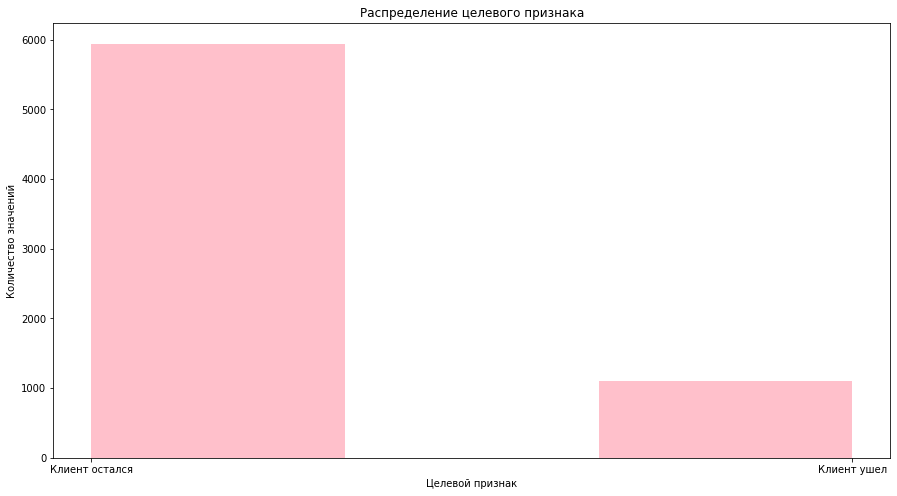

In [48]:
# посмотрим на распределение целевого признака

plt.figure(figsize=(15,8))
plt.hist(all_data['refused'].replace([0, 1], ['Клиент остался', 'Клиент ушел']), color='pink', bins=3)
plt.title('Распределение целевого признака')
plt.ylabel('Количество значений')
plt.xlabel('Целевой признак')
plt.show()

In [49]:
all_data['refused'].value_counts(normalize=True)

0    0.843675
1    0.156325
Name: refused, dtype: float64

У нас имеется дисбаланс классов, около 85% клиентов остались, и около 15% ушли. Балансировать это будем при помощи параметра class_weight при обучении моделей.

Удалим признаки с датами и посмотрим на то, как влияют различные признаки на то, ушел клиент или остался. Также построим матрицу корреляции признаков, будем использовать коэффициент phik.

In [50]:
# удаляем даты

all_data = all_data.drop(['BeginDate', 'EndDate'], axis=1)

interval columns not set, guessing: ['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'amount_of_days', 'refused', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


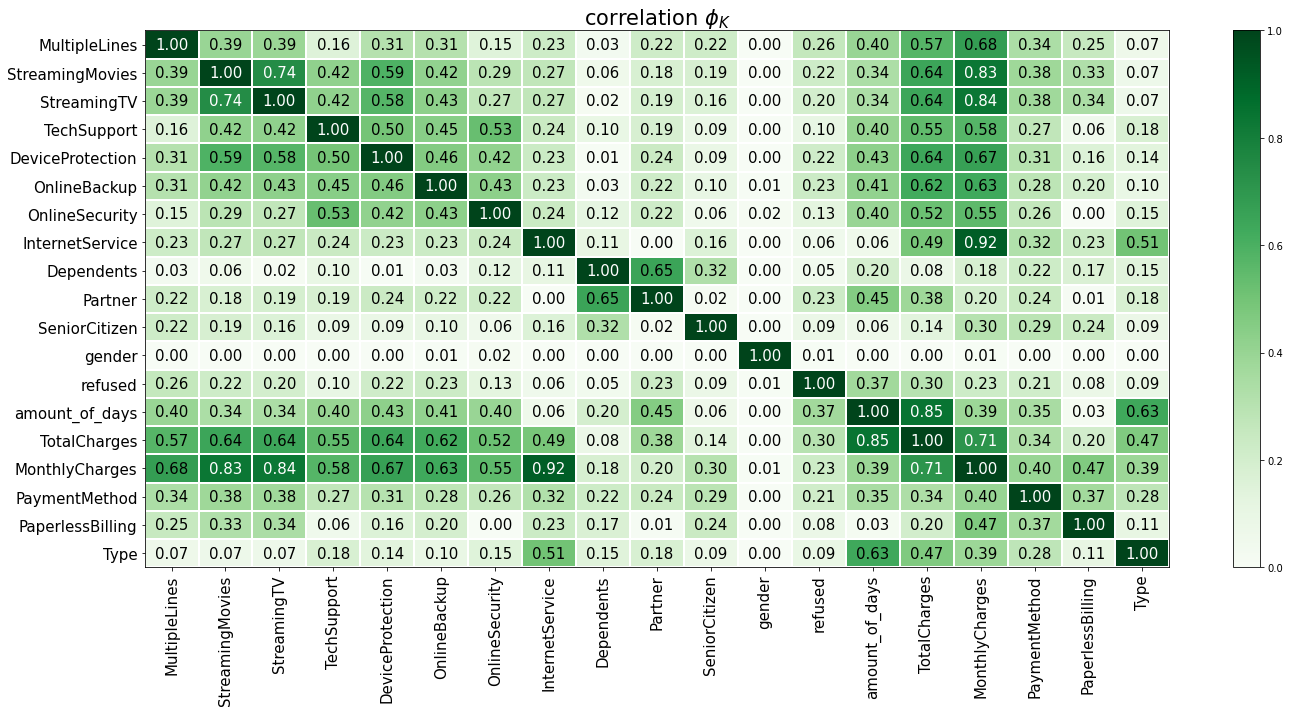

In [51]:
# матрица корреляции в виде тепловой карты

matrix_data = all_data.drop(['customerID'], axis=1)
phik_overview = matrix_data.phik_matrix()

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 10))
plt.tight_layout()

Наиболее высокие значения коэффициента корреляции ожидаемо между месячными тратами и тем, какие услуги клиенту подключены, типом интернет соединения. На суммарную стоимость, конечно, влияет количество дней, в течение которых клиент остаётся клиентом. Из того, что можно еще сказать:

* пол клиента никак и ни на что не влияет, как и пенсионный статус (есть слабая корреляция с месячными расходами, что ожидаемо - пенсионеры не могут платить слишком много), количество иждивенцев средне коррелирует с наличием супруга (очевидно, что при наличии супруга скорее всего на иждивении дети)

* высокая корреляция стримингового ТВ и фильмов в подписке, так как это, по сути связанные услуги

Признаков, которые стоило бы удалить из-за слишком высокого коэффициента корреляции, нет. 

Целевой признак имеет наибольшую корреляцию с количеством дней пользования услугами компании  (0.37) и с суммарными тратами на услуги (0.30). Поэтому в первую очередь посмотрим на то, как влияют именно эти признаки на целевой.

Text(0, 0.5, 'Количество')

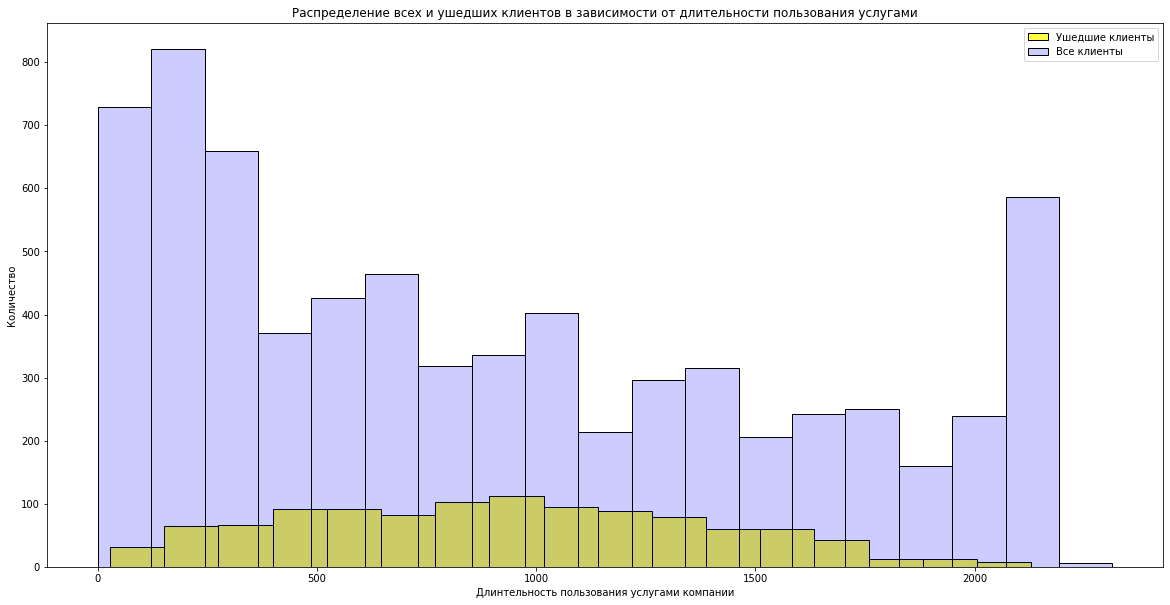

In [52]:
plt.figure(figsize=(20, 10))
ax = sns.histplot(all_data.query('refused == 1')['amount_of_days'], color='yellow', label='Ушедшие клиенты')
sns.histplot(all_data['amount_of_days'], ax=ax, alpha=0.2, label='Все клиенты', color='blue')
ax.legend()
plt.title('Распределение всех и ушедших клиентов в зависимости от длительности пользования услугами')
plt.xlabel('Длинтельность пользования услугами компании')
plt.ylabel('Количество')

Text(0, 0.5, 'Количество')

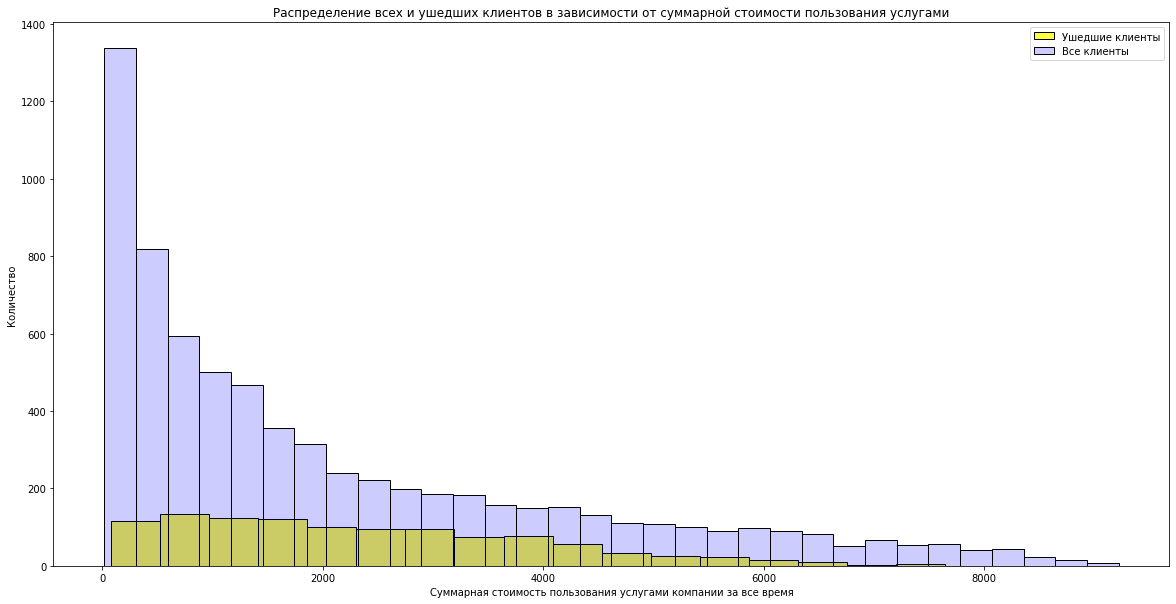

In [53]:
plt.figure(figsize=(20, 10))
ax = sns.histplot(all_data.query('refused == 1')['TotalCharges'], color='yellow', label='Ушедшие клиенты')
sns.histplot(all_data['TotalCharges'], ax=ax, alpha=0.2, label='Все клиенты', color='blue')
ax.legend()
plt.title('Распределение всех и ушедших клиентов в зависимости от суммарной стоимости пользования услугами')
plt.xlabel('Суммарная стоимость пользования услугами компании за все время')
plt.ylabel('Количество')

Посмотрим на влияние месячной стоимости и того, за какой период клиент производит оплату. Во втором случае корреляция слабая очень, но возможно, что те, кто изначально оплатил за более долгий период, дольше и остается клиентом. 

Text(0, 0.5, 'Количество')

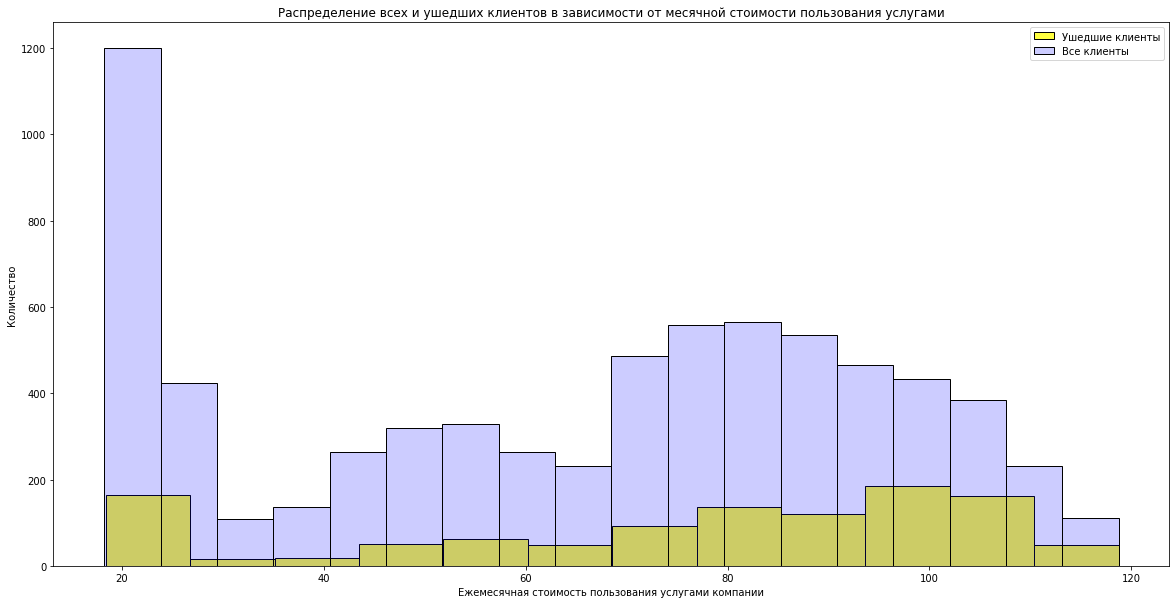

In [54]:
plt.figure(figsize=(20, 10))
ax = sns.histplot(all_data.query('refused == 1')['MonthlyCharges'], color='yellow', label='Ушедшие клиенты')
sns.histplot(all_data['MonthlyCharges'], ax=ax, alpha=0.2, label='Все клиенты', color='blue')
ax.legend()
plt.title('Распределение всех и ушедших клиентов в зависимости от месячной стоимости пользования услугами')
plt.xlabel('Ежемесячная стоимость пользования услугами компании')
plt.ylabel('Количество')

Text(0, 0.5, 'Количество')

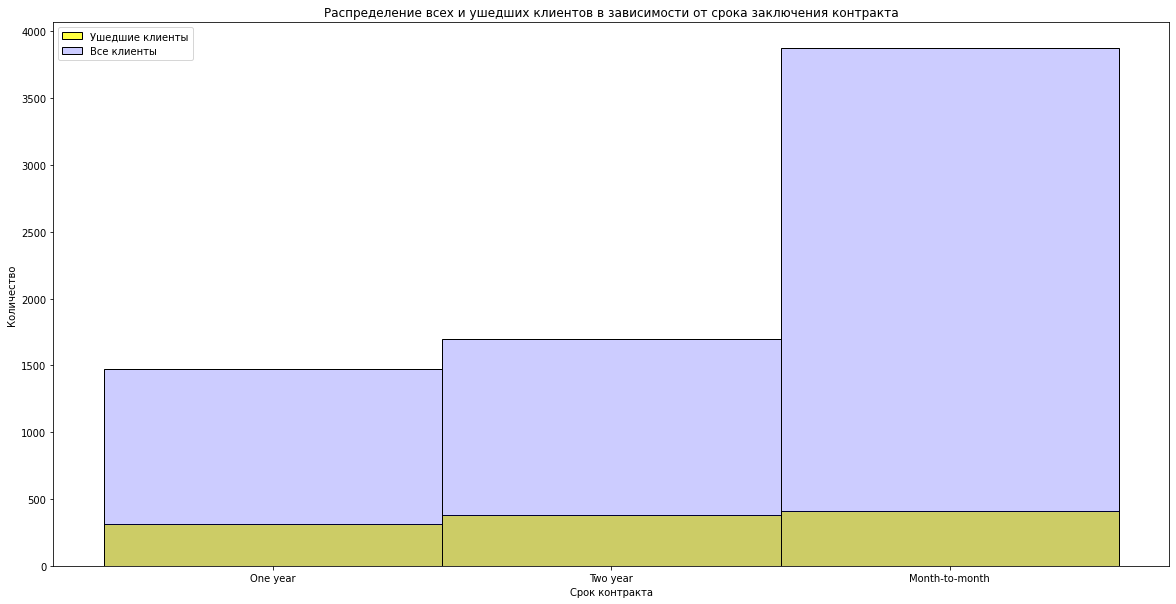

In [55]:
plt.figure(figsize=(20, 10))
ax = sns.histplot(all_data.query('refused == 1')['Type'], color='yellow', label='Ушедшие клиенты')
sns.histplot(all_data['Type'], ax=ax, alpha=0.2, label='Все клиенты', color='blue')
ax.legend()
plt.title('Распределение всех и ушедших клиентов в зависимости от срока заключения контракта')
plt.xlabel('Срок контракта')
plt.ylabel('Количество')

**Из всех построенных выше графиков можно сделать следующие выводы:**

* Меньше всего уходят тех, кто либо только стал клиентом компании и остался недоволен, либо является им очень долгое время.

* Когда на услуги суммарно потратил уже довольно большое кличество денег, то он, как правило, редко уходит. То же касается и наоборот малой суммы, то есть это те, кто недавно только стал клиентом, опять-таки.

* Наибольшая часть ушедших клиентов платили ежемесячно не самую низкую цену. Это может быть причиной ухода - такие же услуги могут у другого оператора стоить дешевле, например. Но есть и пик на минимальной ежемесячной плате. То есть это могут быть те, кто недавно пришел, взял на пробу недорогой тариф, но остался недоволен услугами и ушел.

* Ожидаемо чаще уходят те, кто заключает контракты на месяц, чем те, кто оплатил за год. Но в целом количество оттока для всех типов срока контракта одинаково. 

## Подготовка данных для обучения моделей

In [56]:
#разделим данные сначала на признаки и целевой признак, а потом на обучающую и тестовую выборки
#столбец customerID не информативен для моделей, чтобы не удалять его, можно установить его в качестве индекса
#чтобы сохранить изначальное распределение классов в целевом признаке, установим параметр stratify

all_data = all_data.set_index('customerID')
features = all_data.drop('refused',axis=1)
target = all_data['refused']

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size = 0.25, 
                                                                            random_state = RANDOM_STATE,
                                                                            stratify=target)

In [57]:
target_train.value_counts(normalize=True)

0    0.84362
1    0.15638
Name: refused, dtype: float64

In [58]:
target_test.value_counts(normalize=True)

0    0.843839
1    0.156161
Name: refused, dtype: float64

В обоих Series с целевым признаком сохранилось изначальное распределение, выведенное ранее.

Приступим к кодированию категориальных признаков.В данном проекте будут использоваться ансамблевые бустинговые модели, для них будем использовать их внутреннее кодирование, а также более простые ансамблевая и линейная модели. Для линейных моделей предпочтительнее использовать OHE кодирование, а для леса - OE. Поэтому создадим 2 набора данных с разными способами кодирования. Также масштабируем признаки.

In [59]:
cat = ['Type', 'PaymentMethod', 'InternetService'] #категориальные признаки
num = ['MonthlyCharges', 'TotalCharges', 'amount_of_days'] #количественные признаки

scaler = StandardScaler()

# OE

features_train_oe = features_train.copy()
features_test_oe = features_test.copy()

oe_encoder = OrdinalEncoder()

features_train_oe[cat] = oe_encoder.fit_transform(features_train_oe[cat])
features_test_oe[cat] = oe_encoder.transform(features_test_oe[cat])

features_train_oe[num] = scaler.fit_transform(features_train_oe[num])
features_test_oe[num] = scaler.transform(features_test_oe[num])

features_train_oe.head(7)

Type  PaperlessBilling  PaymentMethod  MonthlyCharges  \
customerID                                                          
5149-TGWDZ   1.0                 1            3.0        1.326419   
6060-QBMGV   2.0                 0            1.0       -1.493975   
7979-CORPM   0.0                 1            1.0        0.860238   
9224-VTYID   2.0                 1            3.0        0.858573   
6701-DHKWQ   2.0                 0            1.0       -0.445068   
6859-QNXIQ   2.0                 1            0.0        1.611123   
6621-YOBKI   0.0                 0            3.0       -1.477326   

            TotalCharges  amount_of_days  gender  SeniorCitizen  Partner  \
customerID                                                                 
5149-TGWDZ      0.044183       -0.370648       1              0        0   
6060-QBMGV     -0.338970        1.806686       0              0        1   
7979-CORPM      0.278039       -0.061060       0              0        0   
9224-VTYID      0.936383        0.693924       0              0        1   
6701-DHKWQ      0.504375        1.405099       1              0        1   
6859-QNXIQ      3.258458        1.892845       1              0        1   
6621-YOBKI     -0.951097       -1.083282       0              0        0   

            Dependents  InternetService  OnlineSecurity  OnlineBackup  \
customerID                                                              
5149-TGWDZ           0              1.0               0             1   
6060-QBMGV           0              2.0               0             0   
7979-CORPM           0              1.0               0             1   
9224-VTYID           1              0.0               1             1   
6701-DHKWQ           1              0.0               0             1   
6859-QNXIQ           1              1.0               1             1   
6621-YOBKI           0              2.0               0             0   

            DeviceProtection  TechSupport  StreamingTV  StreamingMovies  \
customerID                                                                
5149-TGWDZ                 1            1            1                1   
6060-QBMGV                 0            0            0                0   
7979-CORPM                 0            0            1                0   
9224-VTYID                 1            1            1                1   
6701-DHKWQ                 1            1            1                0   
6859-QNXIQ                 1            1            1                1   
6621-YOBKI                 0            0            0                0   

            MultipleLines  
customerID                 
5149-TGWDZ              0  
6060-QBMGV              0  
7979-CORPM              1  
9224-VTYID              1  
6701-DHKWQ              0  
6859-QNXIQ              1  
6621-YOBKI              0

In [84]:
# OHE

features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

#МАСШТАБИРУЕМ

scaler = StandardScaler()

features_train_scaled = pd.DataFrame(scaler.fit_transform(features_train_ohe[num]), columns=[num], index=features_train_ohe.index)
features_test_scaled = pd.DataFrame(scaler.transform(features_test_ohe[num]), columns=[num], index=features_test_ohe.index)

ohe_encoder = OneHotEncoder(handle_unknown='error', drop='first')

features_train_cod = ohe_encoder.fit_transform(features_train_ohe[cat]) 
features_test_cod = ohe_encoder.transform(features_test_ohe[cat]) 

#ОБЪЕДИНЯЕМ МАСШТАБИРОВАННЫЕ КОЛИЧЕСТВЕННЫЕ И КАТЕГОРИАЛЬНЫЕ ЗАКОДИРОВАННЫЕ ПРИЗНАКИ 

features_train_ohe = pd.concat([features_train_scaled, pd.DataFrame(features_train_cod.toarray(), 
                                                                    index=features_train_ohe.index)], 
                                                                    axis=1)
features_test_ohe = pd.concat([features_test_scaled, pd.DataFrame(features_test_cod.toarray(), 
                                                                    index=features_test_ohe.index)], 
                                                                    axis=1)

features_train_ohe.head()

(MonthlyCharges,)  (TotalCharges,)  (amount_of_days,)    0    1  \
customerID                                                                    
5149-TGWDZ           1.326419         0.044183          -0.370648  1.0  0.0   
6060-QBMGV          -1.493975        -0.338970           1.806686  0.0  1.0   
7979-CORPM           0.860238         0.278039          -0.061060  0.0  0.0   
9224-VTYID           0.858573         0.936383           0.693924  0.0  1.0   
6701-DHKWQ          -0.445068         0.504375           1.405099  0.0  1.0   

              2    3    4    5    6  
customerID                           
5149-TGWDZ  0.0  0.0  1.0  1.0  0.0  
6060-QBMGV  1.0  0.0  0.0  0.0  1.0  
7979-CORPM  1.0  0.0  0.0  1.0  0.0  
9224-VTYID  0.0  0.0  1.0  0.0  0.0  
6701-DHKWQ  1.0  0.0  0.0  0.0  0.0

В последнем закодированном датасете получили 7 колонок для 3х признаков. В каждом из категориальных признаков было 3 (Type), 4 (PaymentMethod) и 3 (InternetService) уникальных значений. Суммарно это 10 значений, но так как установлен параметр drop='first', помогающий избежать dummy-ловушки, то в каждом из признаков удален 1й столбце, то есть удалено всего 3 столбца. 10-3 =7, все верно.

## Обучение моделей

Рассмотрим 4 модели:

* LogisticRegression

* RandomForestClassifier

* CatBoostClassifier

* LGBMClassifier

Воспользуемся GridSearchCV для подбора гиперпараметров кросс-валидацией.

### LogisticRegression

In [61]:
# используем датафрейм, закодированный ohe

log_reg = LogisticRegression()
log_parametrs = { 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'],
              'class_weight' : ['balanced'],
              'random_state': [RANDOM_STATE]}
log_grid = GridSearchCV(log_reg, log_parametrs, scoring='roc_auc', cv=5)
log_grid.fit(features_train_ohe, target_train)
print('Значение метрики ROC-AUC: ', log_grid.best_score_)
print('При следующих гиперпараметрах логистической регрессии: ', log_grid.best_params_)

Значение метрики ROC-AUC:  0.7231934456551254
При следующих гиперпараметрах логистической регрессии:  {'class_weight': 'balanced', 'random_state': 250423, 'solver': 'newton-cg'}


### RandomForestClassifier

In [63]:
# используем датафрейм, закодированный oe

forest = RandomForestClassifier()
forest_parametrs = { 'n_estimators': range(100, 701, 100),
                     'max_depth': range(5, 16, 5),
                     'min_samples_split': range(2, 6),
                     'class_weight' : ['balanced'],
                     'random_state': [RANDOM_STATE]}
forest_grid = GridSearchCV(forest, forest_parametrs, scoring='roc_auc', cv=5)
forest_grid.fit(features_train_oe, target_train)
print('Значение метрики ROC-AUC: ', forest_grid.best_score_)
print('При следующих гиперпараметрах случайного леса: ', forest_grid.best_params_)

Значение метрики ROC-AUC:  0.8301534864402396
При следующих гиперпараметрах случайного леса:  {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 700, 'random_state': 250423}


### LightGBM

In [64]:
#LGBM может работать с категориальными признаками, но тип данных должен быть у признаков category
#заменим тип данных в нужных колонках и укажем категориальные данные при обучении

features_train_LGBM = features_train.copy()

features_train_LGBM[cat] = features_train_LGBM[cat].astype('category')


lgb = LGBMClassifier()
lgb_parametrs = {'max_depth': range(5, 16, 5),
                 'learning_rate' : [0.1],
                 'n_estimators' : range (100, 701, 100),
                 'class_weight' : ['balanced'],
                 'random_state': [RANDOM_STATE]}

lgb_grid = GridSearchCV(lgb, lgb_parametrs, scoring='roc_auc', cv=5)
lgb_grid.fit(features_train_LGBM, target_train, categorical_feature=cat)
print('Значение метрики ROC-AUC: ', lgb_grid.best_score_)
print('При следующих гиперпараметрах LightGBM: ', lgb_grid.best_params_)

Значение метрики ROC-AUC:  0.88318844060319
При следующих гиперпараметрах LightGBM:  {'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 600, 'random_state': 250423}


### CatBoost

In [80]:
#CatBoost также не требует кодирования данных

catboost = CatBoostClassifier() 

cb_parametrs = {'iterations': [200],
               'depth': range(8, 15, 2),
               'learning_rate': [0.1],
               'auto_class_weights' : ['Balanced'],
               'random_state': [RANDOM_STATE]}

cb_grid = GridSearchCV(catboost, cb_parametrs, scoring='roc_auc', cv=5)
cb_grid.fit(features_train, target_train, cat_features=cat)
print('Значение метрики ROC-AUC: ', cb_grid.best_score_)
print('При следующих гиперпараметрах CatBoost: ', cb_grid.best_params_)

0:	learn: 0.6589806	total: 18.7ms	remaining: 3.73s
1:	learn: 0.6344549	total: 34.9ms	remaining: 3.45s
2:	learn: 0.6170031	total: 38.9ms	remaining: 2.56s
3:	learn: 0.5922946	total: 50ms	remaining: 2.45s
4:	learn: 0.5741536	total: 61.3ms	remaining: 2.39s
5:	learn: 0.5605376	total: 72.9ms	remaining: 2.36s
6:	learn: 0.5467209	total: 83.8ms	remaining: 2.31s
7:	learn: 0.5356506	total: 95.3ms	remaining: 2.29s
8:	learn: 0.5248915	total: 106ms	remaining: 2.24s
9:	learn: 0.5133991	total: 117ms	remaining: 2.22s
10:	learn: 0.5047918	total: 128ms	remaining: 2.2s
11:	learn: 0.4984207	total: 139ms	remaining: 2.17s
12:	learn: 0.4904898	total: 151ms	remaining: 2.17s
13:	learn: 0.4837531	total: 162ms	remaining: 2.15s
14:	learn: 0.4770315	total: 173ms	remaining: 2.13s
15:	learn: 0.4725371	total: 183ms	remaining: 2.1s
16:	learn: 0.4693056	total: 191ms	remaining: 2.05s
17:	learn: 0.4646683	total: 202ms	remaining: 2.05s
18:	learn: 0.4632171	total: 208ms	remaining: 1.98s
19:	learn: 0.4596667	total: 219ms	rem

Составим сводную таблицу со значениями ROC-AUC для всех использованных моделей. 

In [68]:
models = ['LogisticRegression', 'Random Forest',  'LightGBM', 'Cat Boost']

params = {'ROC-AUC': [0.72, 0.83, 0.88, 0.87]}

result = pd.DataFrame(index=models, data=params, columns=['ROC-AUC'])
display(result)

ROC-AUC
LogisticRegression     0.72
Random Forest          0.83
LightGBM               0.88
Cat Boost              0.87

Самая лучшая модель по метрике ROC_AUC это LightGBM.

## Проверка лучшей модели на тестовой выборке

In [89]:
#подготовим тестовую выборку

features_test_LGBM = features_test.copy()
features_test_LGBM[cat] = features_test_LGBM[cat].astype('category')

best_model = lgb_grid.best_estimator_

probabilities_one = best_model.predict_proba(features_test_LGBM)[:, 1]

print('Значение ROC-AUC на тестовой выборке для лучшей модели: ', roc_auc_score(target_test, probabilities_one))

Значение ROC-AUC на тестовой выборке для лучшей модели:  0.8991447448917167


Отличное значение ROC-AUC. Построим ROC-кривую.

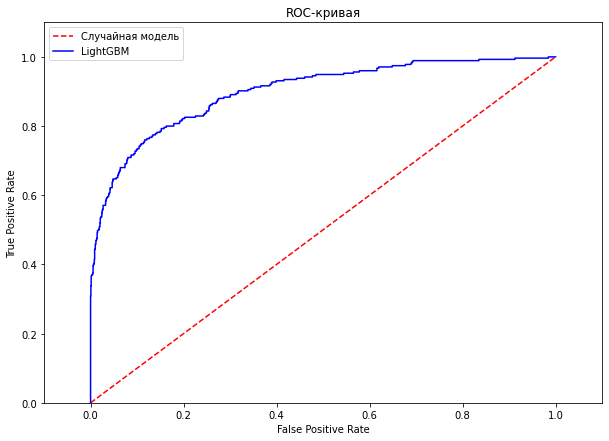

In [95]:
fpr, tpr, tresholds = roc_curve (target_test, probabilities_one)

plt.figure(figsize=(10,7))

plt.plot([0, 1], [0, 1], linestyle='--', color='red') # ROC-кривая случайной модели (выглядит как прямая)
plt.plot(fpr, tpr, color='blue')

plt.xlim([-0.1, 1.1])
plt.ylim([0.0, 1.1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("ROC-кривая")
plt.legend(('Случайная модель','LightGBM'))
plt.show()

Значение ROC-AUC  - это площадь под этой самой ROC-крвой. Для случайной модели оно равно 0.5. Полученное на тестовой выборке значение 0.9 говорит о том, что модель хорошо справляется со своей задачей. Дополнительно посмотрим на матрицу ошибок.

<Figure size 720x720 with 0 Axes>

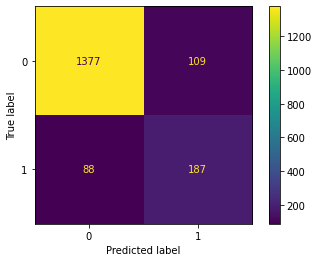

In [101]:
from sklearn.metrics import ConfusionMatrixDisplay #для красивой визуализации матрицы

cm = confusion_matrix(target_test, best_model.predict(features_test_LGBM))
ConfusionMatrixDisplay(cm, best_model.classes_).plot()

True Negative - 1377,

False Positive - 109,

False Negative - 88,

True Positive - 187.

Модель отлично предсказывает объекты класса 0, что обусловлено тем, что распределение классов 0.85 (0) к 0.15 (1). Ошибочно модель пометила 11% объектов (FP, FN).

Проанализируем важность признаков.

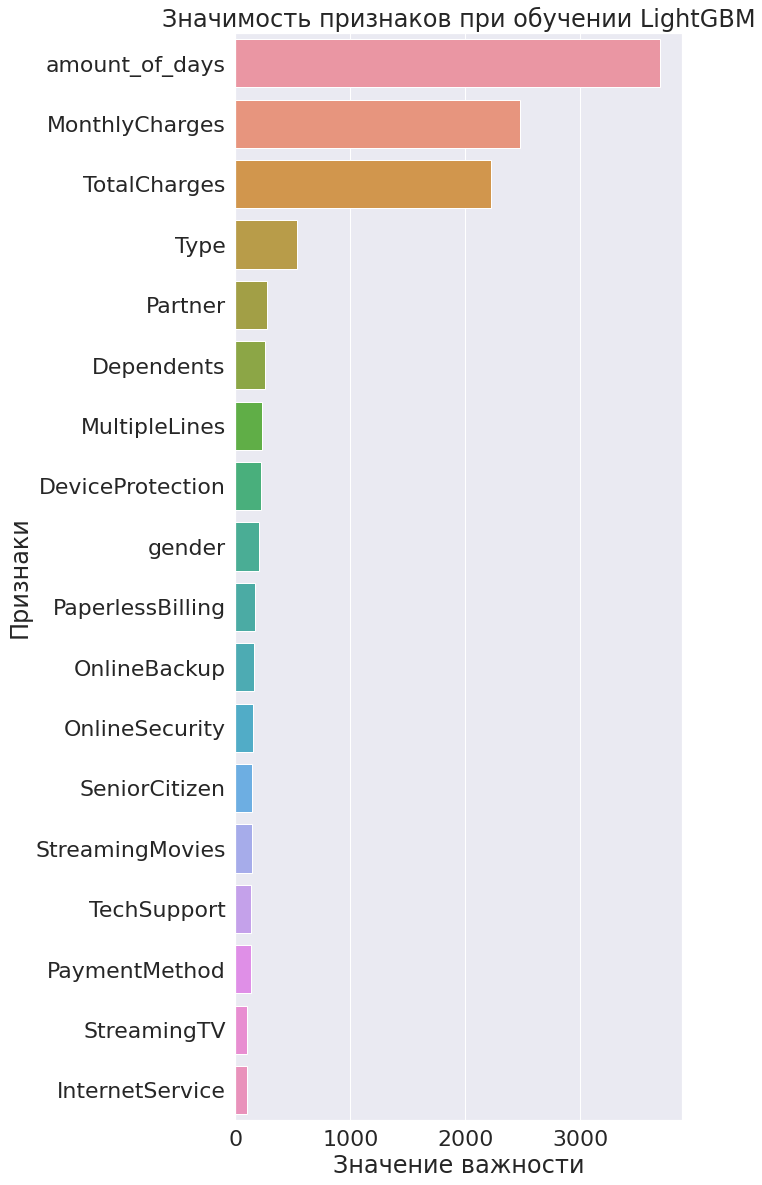

In [122]:
feature_imp = pd.DataFrame({'Значение важности':best_model.feature_importances_,'Признаки':features_train_LGBM.columns})
plt.figure(figsize=(8, 20))
sns.set(font_scale = 2)
sns.barplot(x='Значение важности', y='Признаки', data=feature_imp.sort_values(by='Значение важности', 
                                                        ascending=False))
plt.title('Значимость признаков при обучении LightGBM')
plt.show()

Ожидаемо, наибольшее влияние оказывает количество дней, которое пользователь является клиентом компании, и ежемесячные траты на услуги. 

**Результаты работы и ВЫВОДЫ:**

- при помощи графиков и матрицы корреляции выяснили, что наиболее влияют на целевой признак кол-во дней, в течение которых клиент пользуется услугами компании, а также месячная стоимость услуг для него. (это позже будет подтверждено при исследовании важности признаков).

- Подготовили данные к обучению: разделили на обучающую и тестовую выборки, выделили целевой признак, произвели OHE и OE кодирования для двух моделей, а также масштабирование признаков. Для остальных двух - внутреннее кодирование категориальных признаков.

- в целевом признаке наблюдается дисбаланс классов. При делении на выборки сохранили изначальное распределение и учли его при обучении моделей. 

- Рассмотрели 4 модели: LogisticRegression, RandomForestClassifier, LightGBMClassifier, CatBoostClassifier. Для каждой модели при помощи GridSearchCV кросс-валидацией подобрали гиперпараметры, дающие наилучшее значение метрики. В качестве метрики использовали ROC-AUC. Вот результаты для каждой модели: 

   
    * LogisticRegression : 0.72,  с гиперпараметрами: {'class_weight': 'balanced', 'random_state': 250423, 
                                                                                      'solver': 'newton-cg'}
                                                                                      
    * RandomForestClassifier :  0.83, с гиперпараметрами: {'class_weight': 'balanced', 'max_depth': 10, 
                                                    'min_samples_split': 5, 'n_estimators': 700, 'random_state': 250423}  
                                                    
    * LightGBMClassifier: 0.88, с гиперпараметрами: {'class_weight': 'balanced', 'learning_rate': 0.1, 
                                                              'max_depth': 5, 'n_estimators': 600, 'random_state': 250423} 
                                                              
    * CatBoostClassifier: 0.87, с гиперпараметрами: {'auto_class_weights': 'Balanced', 'depth': 8, 'iterations': 200,                                                                                         'learning_rate': 0.1, 'random_state': 250423}      
- На тестовой выборке тестировали модель LightGBM (хотя обе бустинговые модели показали примерно одинаковый результат, чуть-чуть лучше была эта). На тестовой выборке достигли значения ROC-AUC = 0.899. Также построили ROC-кривую для визуализации результата и сравнения модели со случайной. МАтрица ошибок показала, что модель ожидаемо отлично предсказывает класс с меткой 0, так как в изначальном датасете объектов этого класса в 5,6 раз больше, чем второго. Ошибочных предсказаний около 11%. 

- Анализ значимости признаков показал примерно то же, что и матрица корреляции. Наибольшее влияние оказали длительность пользования услугами компании и ежемесячная стоимость услуг. 

# ОТЧЁТ ПО РЕШЕНИЮ

Задачей этого проекта было построение модели, которая прогнозирует, планирует ли клиент прекращение пользования услугами компании. Важность этой задачи для компании состоит в том, чтобы предложить акции, специальные условия, еще какие-то бонусы, чтобы клиента не потерять.

Предварительно был составлен план работы, все пункты которого были выполнены. Пройдем по каждому шагу более подробно. 

# 1. Исследовательский анализ данных

Нам предоставили 4 датасета, которые содержали информацию о персональных данных клиента, данных по услугам телефонии, данных по интернет-услугам и данных об условиях договоров для каждого клиента. Всего получено данных для 7043 клиентов. 

Каждый из датасетов был подробно изучен: какие столбцы содержит, имеет ли пропуски, аномалии или дубликаты. Приведём названия всех столбцов из всех датасетов с их обозначением:

* customerID - уникальный идентификатор клиента
* BeginDate - дата начала пользования услугами	
* EndDate - дата окончания пользования услугами
* Type - тип договора: ежемесячный, годовой, двухгодовой
* PaperlessBilling - факт выставления счета на электронную почту
* PaymentMethod	- способ оплаты
* MonthlyCharges - ежемесячные траты на услуги	
* TotalCharges - всего потрачено на услуги
* gender - пол клиента
* SeniorCitizen - является ли клиент пенсионером
* Partner - наличие супруга/и у клиента
* Dependents - наличие иждивенцеев	
* InternetService - тип интернет-подключения (оптоволокно, DSL)
* OnlineSecurity - 	услуги интернет-безопасности (например, блокировка небезопасных сайтов, защита от детей)
* OnlineBackup - наличие облачной резервной копии данных
* DeviceProtection - защита устройства (возможно, речь об антивирусе или гарантии на роутер/модем)
* TechSupport - техническая поддержка
* StreamingTV - услуги стримингового ТВ
* StreamingMovies - доступ к фильмотеке
* MultipleLines - наличие возможности ведения параллельных линий во время звонка.

Аномалий и дубликатов выявлено не было, однако имелись неявные пропуски в столбце TotalCharges датафрейма с информацией о контрактах. Также были столбцы с неверными форматами данных: BeginDate и EndDate - object вместо datetime, TotalCharges - object вместо численного.

Также выяснили, что: 

- БОльшая часть ежемесячных платежей приходится на примерно 20 условных денежных единиц. Есть и довольно высокие значения, до 120 у.е. в месяц, скорее всего, это те клиенты, у которых подключено много услуг и телефонии, и интернета, ТВ. Также можно сказать, что имеются четкие пики на круглых числах, это может означать определенные тарифы, цены на которые всегда, как правило округлённые.

- Среди клиентов примерно поровну мужчин и женщин.

- Пенсионеров в 5 раз меньше, чем тех, кто такового статуса не имеет.

- Число тех, кто имеет супруга/у и не имеет - одинаково.

- Клиентов, не имеющих иждивенцев, в 2 раза больше, чем тех, у кого они есть.

- Не на много, но все же больше тех, кто предпочитает подключение через оптоволокно, а не DSL. 

# 2. Предобработка данных

В столбце даты окончания контракта были значения 'No', что говорит о том, что клиент не отказался от услуг компании. Была решено заменить эти значения на последнюю актуальную дату - 1 февраля 2020 года. Выяснили, что все неявные пропуски в столце TotalCharges имеют место для тех дат начала пользования услугами, где это - последняя актуальная дата, то есть это новые пользователи, для которых суммарных платежей нет, поэтому заменили эти пропуски на тот месячный платеж, который они заплатили при подключении. Затем откорректировали типы данных, которые были указаны неверно.

Произвели объединение всех четырёх датафреймов в один по общему столбцу customerID. Получили в результате объединения пропуски, так как не все клиенты пользуются и телефонными услугами, и интернетом. Возникшие пропуски заменили на соответствующие значения, то есть 'No'. Для дальнейшего удобства также перевели столбцы с содержимым 'Yes'/'No', а также стобцы, также содержащие бинарные признаки в иных форматах к виду ноль/единица. Это позволило в дальнейшем осуществить кодирование меньшего числа признаков.

Также создали новый признак, который достаточно важен, - длительность пользования услугами компании, amount_of_days. Получили признак вычитанием из даты окончания пользования услугами компании даты начала пользования услугами.

И, наконец, важнейший шаг - создали целевой признак refused (отказался ли клиент от услуг компании). Там, где дата окончания контракта совпадала с последней актуальной датой, на которую мы заменили значения 'No' в столбце EndDate, там установили значение 0 - клиент НЕ УШЕЛ. Во всех остальных случаях была установлена 1 - УШЕЛ. 

Для дальнейшего (обучение моделей) нам не требуются признаки с датами, поэтому столбцы BeginDate и EndDate были удалены. Также не информативный признак - идентификатор клиента customerID, его установили как индекс.

Распределение целевого признака оказалось таким: 85% клиентов остались, 15% - ушли.

Посмотрели на матрицу корреляции признаков. Был использован коэффициент $\phi$k. Наиболее высокие значения коэффициента корреляции ожидаемо между месячными тратами и тем, какие услуги клиенту подключены, типом интернет соединения. На суммарную стоимость, конечно, особо влияет количество дней, в течение которых клиент остаётся клиентом. Признаков, которые стоило бы удалить из-за слишком высокого коэффициента корреляции, дублирования друг друга не обнаружено. 

Целевой признак имеет наибольшую корреляцию с количеством дней пользования услугами компании (0.37) и с суммарными тратами на услуги (0.30). Поэтому изучили, как именно эти признаки влияют на целевой. Меньше всего уходят тех, кто либо только стал клиентом компании и остался по какой-то причине недоволен (менее выгодные ценовые условия, худшее качество связи/интернета, чем у других операторов), либо является им очень долгое время (привычка, бонусы как давнему клиенту и т.д.). Когда клиент на услуги суммарно потратил уже довольно большое кличество денег, то он, как правило, редко уходит, это коррелирует с длительностью пользования услугами - привык, всё устраивает, получает бонусы за лояльность. То же касается и наоборот малой суммы, то есть это те, кто недавно только стал клиентом, опять-таки. Наибольшая часть ушедших клиентов платили ежемесячно не самую низкую цену. Это может быть причиной ухода - такие же услуги могут у другого оператора стоить дешевле, например. Но есть и пик на минимальной ежемесячной плате. Это могут быть те, кто недавно пришел, взял на пробу недорогой тариф, но остался недоволен услугами, их качеством, и ушел. Ожидаемо чаще уходят те, кто заключает контракты на месяц, чем те, кто оплатил за год. Но в целом количество оттока для всех типов срока контракта почти одинаково.

# 3. Подготовка данных к обучению

На этом шаге мы выделили признаки и целевой признак и разделили данные на две выборки: тестовую и обучающую. Размер обучающей выборки: (5282, 18), тестовой: (1761, 18). То есть 18 признаков и по 5282 и 1761 объектов, соответственно. Размер тестовой выборки от всех данных: 0.25. Также при разделении выполнили стратификацию, чтобы сохранить изначальное распределение классов.

В выборках были категориальные, не приведённые к числовому формату, признаки: 'Type', 'PaymentMethod', 'InternetService'. И количественные: 'MonthlyCharges', 'TotalCharges', 'amount_of_days'. Для приведения категориальных данных в числовую форму, произвели их кодирование. Причем, было использовано 2 способа: One Hot Encoding и Ordinal Encoding. То есть создали 2 набора данных. Так сделали из-за того, что для линейных моделей предпочтительнее использовать OHE кодирование, а для леса - OE. Для бустинговых моделей будет использоваться их внутреннее кодирование (в параметрах будут указаны категориальные признаки при обучении). Также на этом шагу масштабировали численные признаки. 

Установили значение параметра random_state равным 250423.

# 4. Обучение моделей и выбор лучшей

На этом шаге при помощи GridSearchCV обучили модели и кросс-валидацией нашли наилучшие для них гиперпараметры, при которых выбранная метрика качества модели - ROC-AUC, была наивысшей. Был учтён дисбаланс классов при помощи установки параметра 'class_weight'='balanced'.

Было рассмотрено 4 модели:

* LogisticRegression

* RandomForestClassifier

* CatBoostClassifier

* LGBMClassifier

**Признаки, которые были использованы для обучения:**

1. Type - тип договора: ежемесячный, годовой, двухгодовой
2. PaperlessBilling - факт выставления счета на электронную почту
3. PaymentMethod - способ оплаты
4. MonthlyCharges - ежемесячные траты на услуги
5. TotalCharges - всего потрачено на услуги
6. gender - пол клиента
7. SeniorCitizen - является ли клиент пенсионером
8. Partner - наличие супруга/и у клиента
9. Dependents - наличие иждивенцеев
10. InternetService - тип интернет-подключения (оптоволокно, DSL)
11. OnlineSecurity - услуги интернет-безопасности (например, блокировка небезопасных сайтов, защита от детей)
12. OnlineBackup - наличие облачной резервной копии данных
13. DeviceProtection - защита устройства (возможно, речь об антивирусе или гарантии на роутер/модем)
14. TechSupport - техническая поддержка
15. StreamingTV - услуги стримингового ТВ
16. StreamingMovies - доступ к фильмотеке
17. MultipleLines - наличие возможности ведения параллельных линий во время звонка
18. amount_of_days - количество дней, в течение которых клиент пользуется услугами

**Целевой признак:**
 
 - refused - остался ли клиент или ушел.

Вот, какие значения метрики получили для каждой из четырёх выбранных моделей:

| Название модели    | Значение ROC-AUC | 
|--------------------|------------------|
| LogisticRegression | 0.72             | 
| Random Forest      | 0.83             | 
| LightGBM           | 0.88             |
| CatBoost           | 0.87             |

Лучшей моделью стала LightGBMClassifier со следующими гиперпараметрами: 'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 600, 'random_state': 250423. Именно эту модель протестировали на тестовой выборке.

# 5. Проверка лучшей модели на тестовой выборке

Как уже было сказано выше, наилучше моделью оказалась  LightGBMClassifier со следующими гиперпараметрами:  

| Гиперпараметр      | Значение         | 
|--------------------|------------------|
| class_weight       | balanced         | 
| learning_rate      | 0.1              | 
| max_depth          | 5                |
| n_estimators       | 600              |
| random_state       | 250423           |

На тестовой выборке получили значение ROC-AUC, равное 0.899. Это хороший результат! 

Для сравнения нашей модели со случайной была построена ROC-кривая. Наглядно показано высокое качество нашей выбранной модели. 

Также на этом шаге проанализировали матрицу ошибок. То есть то, насколько хорошо модель предсказывает каждый из классов. Получили следующие результаты:

* True Negative - 1377,

* False Positive - 109,

* False Negative - 88,

* True Positive - 187.

Модель отлично предсказывает объекты класса 0 (True Negative), что обусловлено тем, что распределение классов 0.85 (0) к 0.15 (1). Ошибочно модель пометила всего 11% объектов (FP, FN).

Анализ важности признаков показал, что наибольшее влияние оказывает количество дней, которое пользователь является клиентом компании, и ежемесячные траты на услуги.